## Plot PCA

In [1]:
import pandas as pd 
import numpy as np

import math, os

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")
from loess.loess_2d import loess_2d

pd.set_option('display.max_columns', 50)
#matplotlib inline
os.getcwd()


'/Users/chririn/Documents/Code/2D_analysis'

In [2]:
def front(self, n):
    return self.iloc[:, :n]

def back(self, n):
    return self.iloc[:, -n:]

pd.DataFrame.front = front
pd.DataFrame.back = back

# consider making this into a utility
# https://stackoverflow.com/questions/30608310/is-there-a-pandas-function-to-display-the-first-last-n-columns-as-in-head 

In [3]:
figformat = 'png'
dpi = 150

In [4]:
BaseDir = "results"
OutputDir = 'PCA'

if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)

## Load data

In [5]:
df = pd.read_csv('{}/colo44_cleaned_data.csv'.format(BaseDir), sep=';' , index_col=0)
df.back(27).head(1)

,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,well_id,site,ImageID,barcode,plate_well,batch_id,solvent,stock_conc,stock_conc_unit,cmpd_vol,cmpd_vol_unit,well_vol,well_vol_unit,pert_type,cmpd_conc,cmpd_conc_unit,batchid,cbkid,libid,libtxt,smiles,inchi,inkey,conc,compound,Count_nuclei
0,0.426303,B02,1,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B02_1,colo44-v1-FA-P017365-CACO2-48h-P1-L1,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B02,PHB000015,dmso,10.0,mM,7.5,nL,30,uL,poscon,2.5,uM,PHB000015,[tetr],[tetr],pharmb_io,NaN,NaN,NaN,2.5,[tetr],74.0


In [6]:
# Some information about the experiment
listOfPlates = df['barcode'].unique()
NrOfPlates = len(listOfPlates)
print('Number of plates: %s' %(NrOfPlates))
Wells = sorted(list(set(df['well_id'])))
NrOfWells = len(Wells)
print('Number of wells: %s' %(NrOfWells))
Rows = sorted(list(set([w[0] for w in Wells])))
print(*Rows)
NrOfRows = len(Rows)
Columns = sorted(list(set([w[1:] for w in Wells])))
NrOfColumns = len(Columns)
print(*Columns)

Number of plates: 4
Number of wells: 308
B C D E F G H I J K L M N O
02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23


## PCA

High SD wells 

In [17]:
numeric_columns = list()
for a in df.columns:
    if (df.dtypes[a] == 'float64') | (df.dtypes[a] == 'int64'):
        numeric_columns.append(a)
print('Found {} numeric columns'.format(len(numeric_columns)))

DatasetNumeric = df[numeric_columns]
DatasetNumericAndLabels = df[['plate_well','barcode','compound'] + DatasetNumeric.columns.tolist()]

dictOfnumeric = { i : np.nanmean for i in DatasetNumericAndLabels.columns[3:].tolist()}
groupedbyImage = DatasetNumericAndLabels.groupby(['plate_well','barcode','compound']).agg(dictOfnumeric)

#groupedbyImage_var = groupedbyImage.loc[:, groupedbyImage.std() > 0.001].copy() #remove invariant features and features with std below some cut-off
groupedbyImage_var = groupedbyImage.copy()
#print('Excluded features with SD < 0.001 and SD > 10000: {}'.format(groupedbyImage_var.shape[1]))

#groupedbyImage_var.dropna(axis=1, inplace=True)
#print('Removed features with missing values: {}'.format(groupedbyImage_var.shape[1]))
varying_features = list(groupedbyImage_var.columns)

groupedbyImage_var.reset_index(inplace=True)



#groupedbyImage_var[['plate', 'well', 'site', 'compound']] = groupedbyImage_var['ImageID'].str.split(';', expand=True)

#groupedbyImage['compound'] = groupedbyImage['ImageID'].str.split(';')[2]
#groupedbyImage['plate'] = groupedbyImage['ImageID'].str.split(';')[0]
# groupedbyImage_var['CONCuM'] = np.round(groupedbyImage_var['CONCuM'], 5)

Found 2189 numeric columns


In [20]:
groupedbyImage_var.iloc[:, 3:-6].head()

,ObjectNumber_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,AreaShape_ConvexArea_nuclei,AreaShape_Eccentricity_nuclei,AreaShape_EquivalentDiameter_nuclei,AreaShape_EulerNumber_nuclei,AreaShape_Extent_nuclei,AreaShape_FormFactor_nuclei,AreaShape_MajorAxisLength_nuclei,AreaShape_MaxFeretDiameter_nuclei,AreaShape_MaximumRadius_nuclei,AreaShape_MeanRadius_nuclei,AreaShape_MedianRadius_nuclei,AreaShape_MinFeretDiameter_nuclei,AreaShape_MinorAxisLength_nuclei,AreaShape_Orientation_nuclei,AreaShape_Perimeter_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_4_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_4_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_4_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_5_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_5_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_5_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_6_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_6_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_6_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_6_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_7_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_7_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_7_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_7_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,site
0,96.777778,2009.555556,2844.333333,1189.611111,1093.888889,1133.444444,1043.333333,1159.317691,1070.720391,1.207018,2117.000000,0.690041,50.521907,1.0,0.721818,0.828760,61.038691,61.617522,20.513957,7.827197,7.072329,42.598245,42.733306,-1.611525,178.075713,...,-0.872665,-0.004924,0.050943,-0.150384,-0.108243,-0.109599,0.872665,-0.236427,0.119216,0.168704,0.161120,-0.060097,0.086878,-0.082305,-0.174533,-0.023008,-0.151709,-0.454933,0.047269,0.086805,0.142739,0.070926,0.118604,0.160569,5.00
1,154.722222,2157.777778,3108.777778,1118.722222,1163.611111,1061.500000,1108.722222,1089.941533,1135.811161,1.205351,2279.888889,0.700500,52.291660,1.0,0.722664,0.830009,63.629049,63.908197,21.160001,8.070173,7.238091,43.906802,43.995402,2.951725,184.202617,...,-1.570796,-0.267546,-0.033949,-0.298454,-0.157683,-0.168691,1.570796,-0.112445,-0.018023,-0.227359,0.102345,0.219273,0.050214,-0.040733,-0.872665,0.145656,0.086328,0.201228,-0.138987,0.064136,-0.056518,0.166204,-0.182597,0.049534,5.00
2,162.357143,2157.928571,3049.000000,1210.857143,1252.571429,1157.928571,1198.142857,1184.816258,1225.335896,1.211957,2263.285714,0.700859,52.305757,1.0,0.716857,0.825333,63.172484,64.070765,21.136003,8.069879,7.310836,43.847994,43.927925,5.868974,183.703649,...,-1.570796,-0.045034,0.098089,-0.293397,-0.350347,0.132071,1.121997,-0.095614,0.076353,-0.209327,0.540936,0.168240,-0.126486,-0.123528,-0.673198,-0.035640,-0.051025,0.107197,0.064256,-0.301884,-0.015134,-0.272419,-0.226369,-0.276088,4.00
3,113.777778,2110.555556,3002.111111,1075.833333,1227.611111,1016.722222,1172.444444,1046.443952,1199.829376,1.213600,2211.222222,0.701454,51.697568,1.0,0.716296,0.824365,62.807936,63.065325,20.671025,7.970946,7.241164,43.087217,43.268827,4.280734,181.567198,...,-1.570796,-0.080032,0.068552,-0.224307,0.081943,0.067373,1.570796,0.003540,0.130770,-0.066690,0.435694,-0.181225,-0.119546,0.07

In [25]:
x = groupedbyImage_var.iloc[:, 4:-6].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)

In [31]:
ImagePrincipalDf = pd.DataFrame(data = principalComponents)
ImagePrincipalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2', 2: 'principal component 3',3: 'principal component 4',4: 'principal component 5'}, inplace=True)
ImagePrincipalDf['conc'] = groupedbyImage_var['conc']
ImagePrincipalDf['compound'] = groupedbyImage_var['compound']
ImagePrincipalDf['barcode'] = groupedbyImage_var['barcode']


In [32]:
for i in range(len(listOfPlates)):
    ImagePrincipalDf.loc[ImagePrincipalDf['barcode'] == listOfPlates[i], 'plate'] = int(i)


ImagePrincipalDf.loc[ImagePrincipalDf['compound'] == '[dmso]', 'conc'] = 0

ImagePrincipalDf['ctr'] = 0
ImagePrincipalDf.loc[ImagePrincipalDf['compound'] == '[dmso]', 'ctr'] = 1

In [33]:
ImagePrincipalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,conc,compound,barcode,plate,ctr
0,16.926633,-17.113419,6.920580,-11.070373,-3.360502,2.50000,[tetr],colo44-v1-FA-P017365-CACO2-48h-P1-L1,0.0,0
1,-7.473467,-23.997556,4.213709,3.727247,0.455657,0.00833,regora,colo44-v1-FA-P017365-CACO2-48h-P1-L1,0.0,0
2,-10.662336,-25.888090,3.642412,9.275074,5.814125,0.00000,[dmso],colo44-v1-FA-P017365-CACO2-48h-P1-L1,0.0,1
3,3.062989,-8.611153,2.016410,-2.271036,0.044780,0.10000,cobime,colo44-v1-FA-P017365-CACO2-48h-P1-L1,0.0,0
4,-12.204815,-15.196195,-0.229926,3.362041,0.965268,0.10000,Encora,colo44-v1-FA-P017365-CACO2-48h-P1-L1,0.0,0


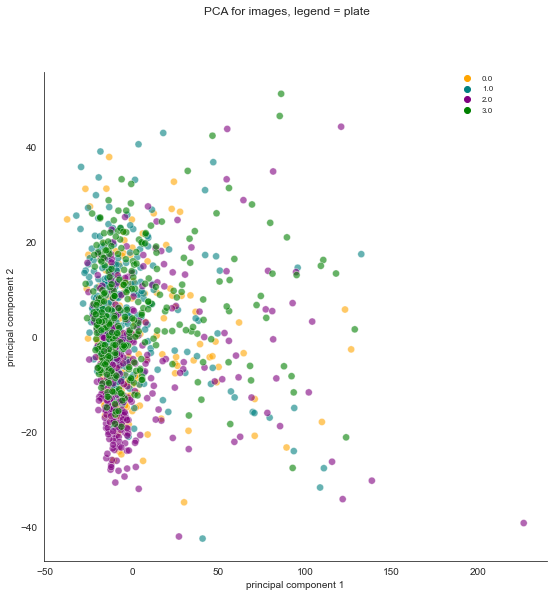

In [34]:
hue= 'plate'

pal=['orange', 'teal', 'purple', 'green']

fig = plt.figure(figsize = (9,9))
fig.suptitle('PCA for images, legend = {}'.format(hue), fontsize = 12)
ax = fig.add_subplot()

ax =sns.scatterplot(x='principal component 1', y='principal component 2',
              hue=hue, data=ImagePrincipalDf, palette=pal,  s=50, alpha = 0.6, marker = 'o');

ax.legend(bbox_to_anchor = (0.9, 1),borderaxespad = 0, fontsize = 8, frameon = False)
#ax.set_xlim([-50, 100])
#ax.set_ylim([-40, 60])
# ax.get_legend().remove()
sns.despine()
fig.savefig('{}/PC1_PC2_{}.{}'.format(OutputDir, hue, figformat),  dpi=dpi)

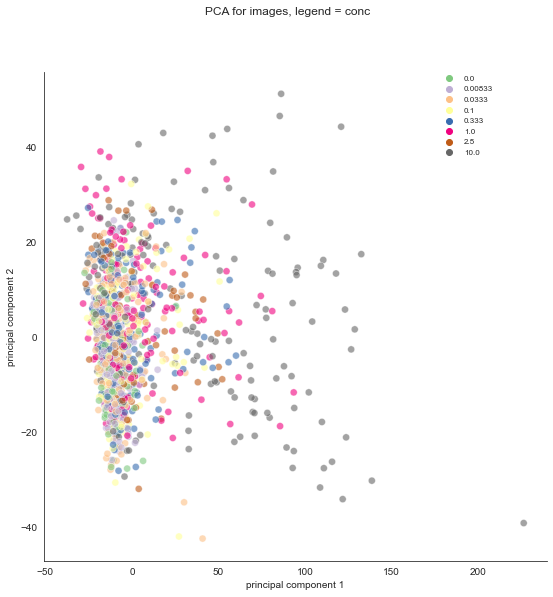

In [35]:
hue= 'conc'

pal='Accent'

fig = plt.figure(figsize = (9,9))
fig.suptitle('PCA for images, legend = {}'.format(hue), fontsize = 12)
ax = fig.add_subplot()

ax =sns.scatterplot(x='principal component 1', y='principal component 2',
              hue=hue, data=ImagePrincipalDf, palette=pal,  s=50, alpha = 0.6, marker = 'o');

ax.legend(bbox_to_anchor = (0.9, 1),borderaxespad = 0, fontsize = 8, frameon = False)
#ax.set_xlim([-50, 100])
#ax.set_ylim([-40, 60])
# ax.get_legend().remove()
sns.despine()
fig.savefig('{}/PC1_PC2_{}.{}'.format(OutputDir, hue, figformat),  dpi=dpi)

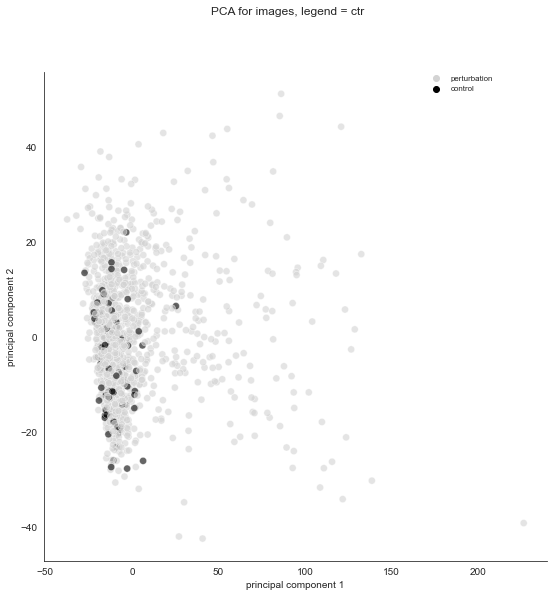

In [48]:
hue= 'ctr'

pal=['lightgray', 'black']

fig = plt.figure(figsize = (9,9))
fig.suptitle('PCA for images, legend = {}'.format(hue), fontsize = 12)
ax = fig.add_subplot()

ax =sns.scatterplot(x='principal component 1', y='principal component 2',
              hue=hue, data=ImagePrincipalDf, palette=pal,  s=50, alpha = 0.6, marker = 'o');

l = ax.legend(bbox_to_anchor = (0.9, 1),borderaxespad = 0, fontsize = 8, frameon = False)
#ax.set_xlim([-50, 100])
#ax.set_ylim([-40, 60])
# ax.get_legend().remove()
l.get_texts()[0].set_text('perturbation')
l.get_texts()[1].set_text('control')

sns.despine()
fig.savefig('{}/PC1_PC2_{}.{}'.format(OutputDir, hue, figformat),  dpi=dpi)

DMSO loading

In [97]:
dfDMSO = df.loc[(df['compound'] == '[dmso]')]
dfDMSO.head(1)

,ObjectNumber_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,AreaShape_ConvexArea_nuclei,AreaShape_Eccentricity_nuclei,AreaShape_EquivalentDiameter_nuclei,AreaShape_EulerNumber_nuclei,AreaShape_Extent_nuclei,AreaShape_FormFactor_nuclei,AreaShape_MajorAxisLength_nuclei,AreaShape_MaxFeretDiameter_nuclei,AreaShape_MaximumRadius_nuclei,AreaShape_MeanRadius_nuclei,AreaShape_MedianRadius_nuclei,AreaShape_MinFeretDiameter_nuclei,AreaShape_MinorAxisLength_nuclei,AreaShape_Orientation_nuclei,AreaShape_Perimeter_nuclei,...,site,ImageID,barcode,plate_well,batch_id,solvent,stock_conc,stock_conc_unit,cmpd_vol,cmpd_vol_unit,well_vol,well_vol_unit,pert_type,cmpd_conc,cmpd_conc_unit,batchid,cbkid,libid,libtxt,smiles,inchi,inkey,conc,compound,Count_nuclei
18,190.0,1626.0,2464.0,1547.0,1369.0,1505.0,1315.0,1529.344762,1342.660085,1.257303,1730.0,0.708035,45.500412,1.0,0.692442,0.795353,56.743355,58.051701,18.0,6.806873,6.324555,38.693038,37.970996,10.832059,166.160426,...,1,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B05_1,colo44-v1-FA-P017365-CACO2-48h-P1-L1,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B05,PHB000001,dmso,100.0,perc,30.0,nL,30,uL,negcon,0.1,perc,PHB000001,[dmso],[dmso],compound_center,NaN,NaN,NaN,0.1,[dmso],193.0


In [98]:
numeric_columns = list()
for a in df.columns:
    if (dfDMSO.dtypes[a] == 'float64') | (dfDMSO.dtypes[a] == 'int64'):
        numeric_columns.append(a)
print('Found {} numeric columns'.format(len(numeric_columns)))

DatasetNumeric = dfDMSO[numeric_columns]
DatasetNumericAndLabels = dfDMSO[['plate_well','barcode','compound'] + DatasetNumeric.columns.tolist()]

dictOfnumeric = { i : np.nanmean for i in DatasetNumericAndLabels.columns[3:].tolist()}
groupedbyImage = DatasetNumericAndLabels.groupby(['plate_well','barcode','compound']).agg(dictOfnumeric)

#groupedbyImage_var = groupedbyImage.loc[:, groupedbyImage.std() > 0.001].copy() #remove invariant features and features with std below some cut-off
groupedbyImage_varDMSO = groupedbyImage.copy()
#print('Excluded features with SD < 0.001 and SD > 10000: {}'.format(groupedbyImage_var.shape[1]))

#groupedbyImage_var.dropna(axis=1, inplace=True)
#print('Removed features with missing values: {}'.format(groupedbyImage_var.shape[1]))
varying_features = list(groupedbyImage_varDMSO.columns)

groupedbyImage_varDMSO.reset_index(inplace=True)

Found 2189 numeric columns


In [105]:
groupedbyImage_varDMSO.head(1)
groupedbyImage_varDMSO.iloc[:, 3:-7].head(1)

,ObjectNumber_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,AreaShape_ConvexArea_nuclei,AreaShape_Eccentricity_nuclei,AreaShape_EquivalentDiameter_nuclei,AreaShape_EulerNumber_nuclei,AreaShape_Extent_nuclei,AreaShape_FormFactor_nuclei,AreaShape_MajorAxisLength_nuclei,AreaShape_MaxFeretDiameter_nuclei,AreaShape_MaximumRadius_nuclei,AreaShape_MeanRadius_nuclei,AreaShape_MedianRadius_nuclei,AreaShape_MinFeretDiameter_nuclei,AreaShape_MinorAxisLength_nuclei,AreaShape_Orientation_nuclei,AreaShape_Perimeter_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_4_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_4_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_4_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_5_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_5_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_5_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_6_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_6_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_6_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_6_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_7_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_7_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_7_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_7_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,site
0,162.357143,2157.928571,3049.0,1210.857143,1252.571429,1157.928571,1198.142857,1184.816258,1225.335896,1.211957,2263.285714,0.700859,52.305757,1.0,0.716857,0.825333,63.172484,64.070765,21.136003,8.069879,7.310836,43.847994,43.927925,5.868974,183.703649,...,-1.570796,-0.045034,0.098089,-0.293397,-0.350347,0.132071,1.121997,-0.095614,0.076353,-0.209327,0.540936,0.16824,-0.126486,-0.123528,-0.673198,-0.03564,-0.051025,0.107197,0.064256,-0.301884,-0.015134,-0.272419,-0.226369,-0.276088,4.0


In [106]:
x = groupedbyImage_varDMSO.iloc[:, 3:-7].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)

In [113]:
ImagePrincipalDf = pd.DataFrame(data = principalComponents)
ImagePrincipalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2', 2: 'principal component 3',3: 'principal component 4',4: 'principal component 5'}, inplace=True)
ImagePrincipalDf['conc'] = groupedbyImage_varDMSO['conc']
ImagePrincipalDf['compound'] = groupedbyImage_varDMSO['compound']
ImagePrincipalDf['barcode'] = groupedbyImage_varDMSO['barcode']

In [114]:
for i in range(len(listOfPlates)):
    ImagePrincipalDf.loc[ImagePrincipalDf['barcode'] == listOfPlates[i], 'plate'] = int(i)

In [115]:
ImagePrincipalDf.tail()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,conc,compound,barcode,plate
91,-25.530697,15.911165,3.371967,-0.031245,1.501659,0.1,[dmso],colo44-v1-FA-P017368-CACO2-48h-P2-L2,3.0
92,32.525117,16.643577,-12.246127,-12.197649,10.921474,0.1,[dmso],colo44-v1-FA-P017368-CACO2-48h-P2-L2,3.0
93,-30.850389,5.590214,-8.392322,0.413320,-10.397463,0.1,[dmso],colo44-v1-FA-P017368-CACO2-48h-P2-L2,3.0
94,26.736069,32.504759,1.866732,-12.183832,0.626926,0.1,[dmso],colo44-v1-FA-P017368-CACO2-48h-P2-L2,3.0
95,2.255661,33.986504,27.592217,-19.550253,-0.292302,0.1,[dmso],colo44-v1-FA-P017368-CACO2-48h-P2-L2,3.0


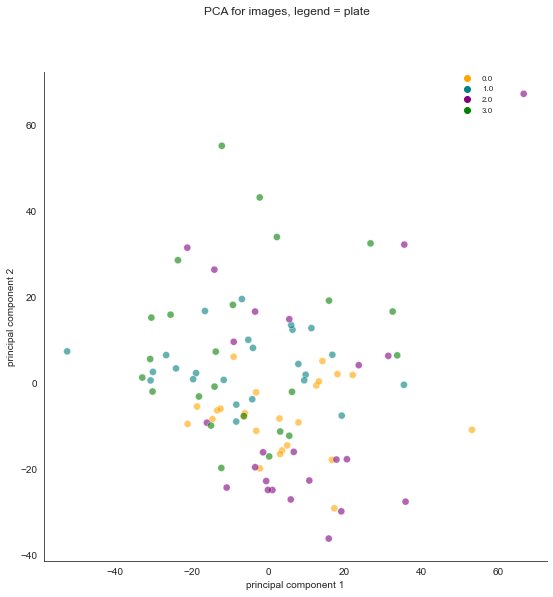

In [116]:
hue= 'plate'

pal=['orange', 'teal', 'purple', 'green']

fig = plt.figure(figsize = (9,9))
fig.suptitle('PCA for images, legend = {}'.format(hue), fontsize = 12)
ax = fig.add_subplot()

ax =sns.scatterplot(x='principal component 1', y='principal component 2',
              hue=hue, data=ImagePrincipalDf, palette=pal,  s=50, alpha = 0.6, marker = 'o');

ax.legend(bbox_to_anchor = (0.9, 1),borderaxespad = 0, fontsize = 8, frameon = False)
#ax.set_xlim([-50, 100])
#ax.set_ylim([-40, 60])
# ax.get_legend().remove()
sns.despine()
fig.savefig('{}/PC1_PC2_{}.{}'.format(OutputDir, hue, figformat),  dpi=dpi)

In [117]:
ColumnsToUse = groupedbyImage_var.iloc[:, 3:-7].columns
print(ColumnsToUse)

Index(['ObjectNumber_nuclei', 'AreaShape_Area_nuclei',
       'AreaShape_BoundingBoxArea_nuclei',
       'AreaShape_BoundingBoxMaximum_X_nuclei',
       'AreaShape_BoundingBoxMaximum_Y_nuclei',
       'AreaShape_BoundingBoxMinimum_X_nuclei',
       'AreaShape_BoundingBoxMinimum_Y_nuclei', 'AreaShape_Center_X_nuclei',
       'AreaShape_Center_Y_nuclei', 'AreaShape_Compactness_nuclei',
       ...
       'RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm',
       '

In [122]:
loadingDf = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5'], index=ColumnsToUse)

loadingDf = loadingDf.sort_values(by =['PC3'], ascending = False)
loadingDf.head(10).front(3)

,PC1,PC2,PC3
RadialDistribution_ZernikeMagnitude_illumMITO_8_8_cytoplasm,0.014258,0.001491,0.060770
RadialDistribution_ZernikeMagnitude_illumMITO_9_9_cytoplasm,0.014211,0.004283,0.059632
RadialDistribution_ZernikeMagnitude_illumMITO_8_8_cells,0.010290,0.007002,0.059625
Intensity_MeanIntensityEdge_illumMITO_cells,0.011493,0.014296,0.059237
RadialDistribution_ZernikeMagnitude_illumMITO_2_2_cytoplasm,0.016771,0.003061,0.058538
RadialDistribution_ZernikeMagnitude_illumMITO_3_3_cytoplasm,0.016252,0.012910,0.058316
RadialDistribution_ZernikeMagnitude_illumMITO_6_6_cells,0.010401,0.011239,0.057437
Intensity_MeanIntensityEdge_illumMITO_cytoplasm,0.015650,0.020522,0.056551
Intensity_LowerQuartileIntensity_illumMITO_cytoplasm,0.016100,-0.000288,0.056381
RadialDistribution_ZernikeMagnitude_illumMITO_7_7_cytoplasm,0.016650,0.010482,0.055168


Tryout stuff

In [54]:
ColumnsToUse = groupedbyImage_var.iloc[:, 3:-7].columns
print(ColumnsToUse)

Index(['ObjectNumber_nuclei', 'AreaShape_Area_nuclei',
       'AreaShape_BoundingBoxArea_nuclei',
       'AreaShape_BoundingBoxMaximum_X_nuclei',
       'AreaShape_BoundingBoxMaximum_Y_nuclei',
       'AreaShape_BoundingBoxMinimum_X_nuclei',
       'AreaShape_BoundingBoxMinimum_Y_nuclei', 'AreaShape_Center_X_nuclei',
       'AreaShape_Center_Y_nuclei', 'AreaShape_Compactness_nuclei',
       ...
       'RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm',
       '

In [77]:
loadingDf = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5'], index=ColumnsToUse)

loadingDf = loadingDf.sort_values(by =['PC1'], ascending = False)
loadingDf.head()



,PC1,PC2,PC3,PC4,PC5
Intensity_LowerQuartileIntensity_illumSYTO_cells,0.035831,-0.000628,0.007320,-0.009578,-0.019483
Intensity_MADIntensity_illumMITO_cells,0.035826,0.001841,0.008463,0.004127,-0.017865
Intensity_LowerQuartileIntensity_illumSYTO_nuclei,0.035800,0.003908,0.012323,0.003352,-0.015640
Intensity_StdIntensity_illumMITO_cells,0.035631,0.004928,0.011295,-0.002204,-0.012984
RadialDistribution_ZernikeMagnitude_illumCONC_4_4_nuclei,0.035518,-0.004450,0.015550,-0.008878,-0.000358


In [85]:
print(loadingDf.loc[:, 'PC1'].iloc[:10])

Intensity_LowerQuartileIntensity_illumSYTO_cells                 0.035831
Intensity_MADIntensity_illumMITO_cells                           0.035826
Intensity_LowerQuartileIntensity_illumSYTO_nuclei                0.035800
Intensity_StdIntensity_illumMITO_cells                           0.035631
RadialDistribution_ZernikeMagnitude_illumCONC_4_4_nuclei         0.035518
Intensity_StdIntensity_illumMITO_cytoplasm                       0.035465
RadialDistribution_ZernikeMagnitude_illumPHAandWGA_4_4_nuclei    0.035398
RadialDistribution_ZernikeMagnitude_illumPHAandWGA_1_1_nuclei    0.035369
Intensity_StdIntensityEdge_illumSYTO_nuclei                      0.035317
RadialDistribution_ZernikeMagnitude_illumCONC_1_1_nuclei         0.035293
Name: PC1, dtype: float64


/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_52636/2371156024.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', axis='x', color='lightgrey', linestyle='', linewidth=1, alpha = 1)
/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_52636/2371156024.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', axis='y', color='lightgrey', linestyle='', linewidth=1)


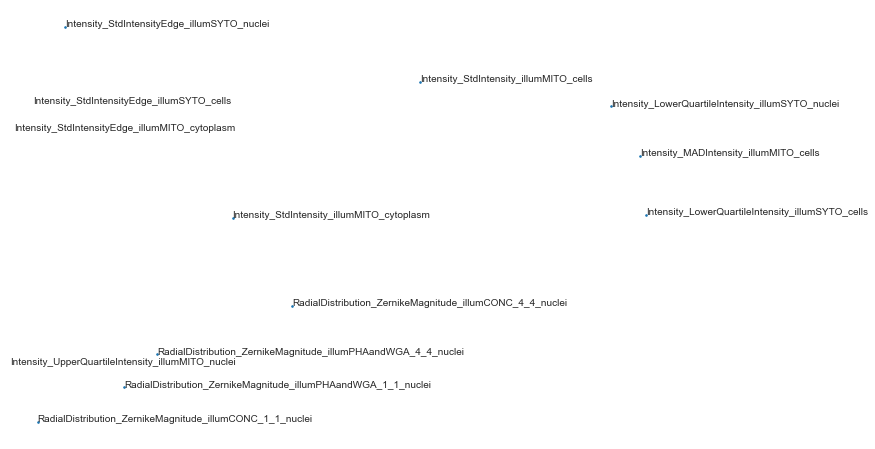

In [93]:
fig = plt.figure(figsize = (12,8))
#fig.suptitle('Loadings of PC1 and PC2 for ' + Channel , fontsize = 15)
ax = fig.add_subplot()
ax.set_facecolor('w')
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
#ax.set_xlim([0, len(principalDf)])
#ax.set_ylim([0, len(principalDf)])
#xticks = np.arange(0, len(principalDf.index), 540)
#ax.set_xticks(xticks)
#ax.set_yticks([LowerLimits[0], 0, UpperLimits[0]])
ax.grid(b=True, which='major', axis='x', color='lightgrey', linestyle='', linewidth=1, alpha = 1)
ax.grid(b=True, which='major', axis='y', color='lightgrey', linestyle='', linewidth=1)
ax.tick_params(axis='x', labelbottom=False)
ax.tick_params(axis='y', labelleft=False)
#ax.set_xlabel('PC 1', fontsize = 15)
#ax.set_ylabel('PC 2', fontsize = 15)
ax.scatter(loadingDf.loc[:, 'PC1'].iloc[:10], loadingDf.loc[:, 'PC2'].iloc[:10],
           marker = '.', s = 10);
for i, txt in enumerate(loadingDf.index):
    ax.annotate((txt[:]), (loadingDf.loc[txt, 'PC1'], loadingDf.loc[txt, 'PC2']))  

#plt.plot([0,100], [LowerLimits[0],LowerLimits[0]], color = 'r', linestyle='-')
#plt.plot([0,100], [UpperLimits[0],UpperLimits[0]], color = 'r', linestyle='-')
#plt.savefig(PathToPlots + '/' + Channel + '_Loadings_PCA_1_2.png', dpi=Resolution)
plt.show()